In [11]:
import torch
import pandas as pd
from torch.autograd import Variable
import torchvision.transforms
from PIL import Image
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.colors as mcolors
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import os
from captum.attr import NoiseTunnel, Saliency, LayerGradCam
from captum.attr import visualization as viz
import pickle

In [105]:
# load own packages
from dataset import CUBDataset
from torch.utils.data import Dataset
from models import get_inception_transform
import sailency
from torchvision import transforms
from sailency import get_saliency_maps
map_location=torch.device('cpu')

In [3]:
import sailency
import matplotlib.pyplot as plt
from data_loaders import CUB_extnded_dataset
from models import get_inception_transform

In [86]:
data_set = 'test' 

#Make the dataset
transform = get_inception_transform(mode=data_set, methode= "center")


config = {'CUB_dir':r'data/CUB_200_2011',
                'split_file':r'data/train_test_val.pkl',
                'use_majority_voting':False,
                'min_class_count':10,
                'return_visibility':False}

data_set = CUB_extnded_dataset(mode=data_set,config_dict=config,transform=transform)

concept_name = data_set.consept_labels_names

class_names = data_set.class_labels_names




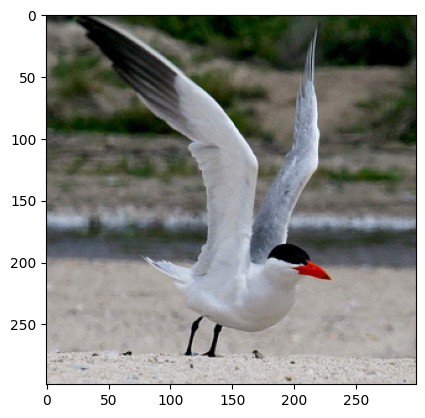

In [83]:


idx = 4099


img, class_label, concept_label, coordinates = data_set[idx]

#plot image
plt.imshow(img.numpy().transpose(1,2,0)*2+0.5)

      
plt.size=(50,50)
plt.show()

In [89]:
#Print name index and coordinates of each concept
for i in range(len(concept_name)):
    print(i,concept_name[i], coordinates[i])

0 has_bill_shape::curved_(up_or_down) [(np.float64(215.0), np.float64(207.0))]
1 has_bill_shape::dagger [(np.float64(215.0), np.float64(207.0))]
2 has_bill_shape::hooked [(np.float64(215.0), np.float64(207.0))]
3 has_bill_shape::needle [(np.float64(215.0), np.float64(207.0))]
4 has_bill_shape::hooked_seabird [(np.float64(215.0), np.float64(207.0))]
5 has_bill_shape::spatulate [(np.float64(215.0), np.float64(207.0))]
6 has_bill_shape::all-purpose [(np.float64(215.0), np.float64(207.0))]
7 has_bill_shape::cone [(np.float64(215.0), np.float64(207.0))]
8 has_bill_shape::specialized [(np.float64(215.0), np.float64(207.0))]
9 has_wing_color::blue [(np.float64(188.0), np.float64(156.0)), (np.float64(148.0), np.float64(146.0))]
10 has_wing_color::brown [(np.float64(188.0), np.float64(156.0)), (np.float64(148.0), np.float64(146.0))]
11 has_wing_color::iridescent [(np.float64(188.0), np.float64(156.0)), (np.float64(148.0), np.float64(146.0))]
12 has_wing_color::purple [(np.float64(188.0), np.flo

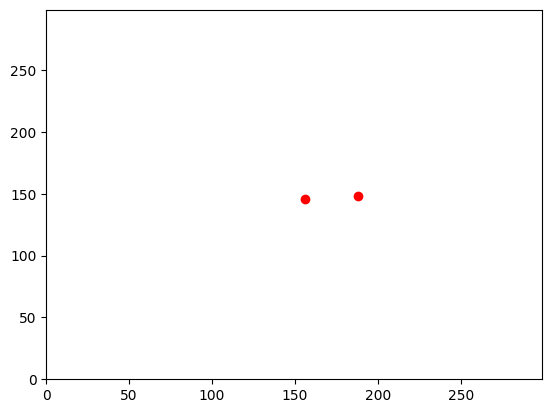

In [96]:
plt.plot(coordinates[10][0],coordinates[10][1],'ro')
plt.xlim(0,299)
plt.ylim(0,299)
plt.size=(50,50)
plt.show()

In [100]:
height, width = 299,299 # Get the dimensions of the saliency map

# Create coordinate grids for the entire map
x_coords,y_coords = np.ogrid[:height, :width]

distances = []

for target_y, target_x in coordinates[10]:
    # Calculate Manhattan distances from each point to the target coordinate
    distances.append(np.abs(y_coords - target_y) + np.abs(x_coords - target_x))

    # Calculate Euclidean distances from each point to the target coordinate
    #distances.append(np.sqrt((y_coords - target_y)**2 + (x_coords - target_x)**2))

if len(distances) ==1: #If only one coordinate return the sum of the score
    M = distances[0]

else:
    # If multiple coordinates return the minimum distance for each coordinate
    M = np.stack(distances).min(axis=0)



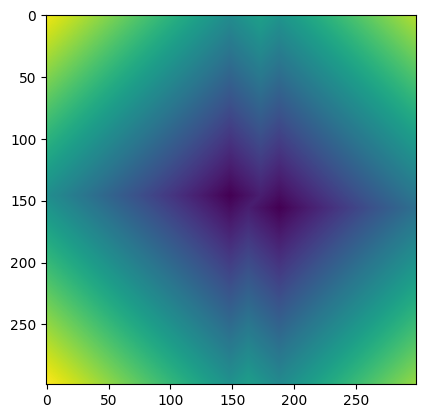

In [101]:
plt.imshow(M)

In [109]:
def plot_sailency(img,sailency_map,concept_ids,concept_names,coordinates=None):
    """
    Plot the sailency map and the coordinates on the image
    args: img: torch.tensor: The image
    sailency_map: list of np.array: The sailency maps
    concept_ids: list of int: List of concepts that need to be plotted (somewhere between 1 and 5)
    concept_names: list of str: The names of the concepts
    coordinates: list of list of tuples: The coordinates to plot
    """

    num_pictures = len(concept_ids)+1
    fig, ax = plt.subplots(1, num_pictures, figsize=(10*num_pictures, 10))
    
    #Plot original image
    ax[0].imshow(img.permute(1, 2, 0))
    ax[0].set_title("Original image",fontsize=20)

    for i,concept_id in enumerate(concept_ids):
        #Plot sailency map
        ax[i+1].imshow(sailency_map[i],cmap='viridis')
        ax[i+1].set_title(concept_names[concept_id])
        ax[i+1].axis('off')

        #Plot coordinates
        if coordinates is not None:
            for x,y in coordinates[concept_id]:
                ax[i+1].plot(x,y,'ro')
            if len(coordinates[concept_id]) > 0:
                score = saliency_score_part(sailency_map[i],coordinates[concept_id])
                ax[i+1].set_title(f"{concept_names[concept_id]} Saliency score: {score:.2f}",fontsize=20)

    plt.show()

C:\Users\Andre\AppData\Local\Temp\ipykernel_13220\3376817067.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  XtoC_Model=torch.load(model_path, map_location=map_location)

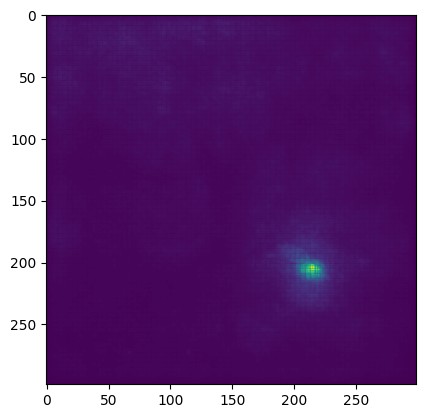

In [116]:
concept_list = [309]
model_path = r'evaluate_models\Concepts_CKPT_NoMajority\best_XtoC_model.pth'
XtoC_Model=torch.load(model_path, map_location=map_location)
XtoC_Model.eval()
sailency_maps = get_saliency_maps(img,concept_list,XtoC_Model,method_type='noise_tunnel')

plt.imshow(sailency_maps[0])

In [ ]:
#Return the score
saliency_score = (saliency_map * M).sum()/M.mean()
print(saliency_score)

In [104]:


"""
Calculate a score of a single part based on the sailency activation times the manhatten distance to the coordinates. 
args: sailency: np.array: The sailency map
cords: list of tuples: The coordinates to calculate the distance to
return: float: The score
"""

height, width = saliency_map.shape  # Get the dimensions of the saliency map

# Create coordinate grids for the entire map
y_coords, x_coords = np.ogrid[:height, :width]

distances = []

for target_y, target_x in coordinates:
    # Calculate Manhattan distances from each point to the target coordinate
    distances.append(np.abs(y_coords - target_y) + np.abs(x_coords - target_x))

if len(distances) ==1: #If only one coordinate return the sum of the score
    M = distances[0]

else:
    # If multiple coordinates return the minimum distance for each coordinate
    M = np.stack(distances).min(axis=0)



NameError: name 'saliency_score' is not defined